In [3]:
# Testing that the machine recognizes the GPU
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [4]:
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
import seaborn as sns
import os
from os.path import isfile
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import utils
import itertools
import shutil
np.random.seed(42)
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [5]:
print(tf.__version__)
print(tf.keras.__version__)

2.6.4
2.6.0


In [6]:
# gpu_options = tf.compat.v1.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.5)
# sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

current_dir = os.getcwd()
print(current_dir)

/kaggle/working


In [7]:

pos_data = []
neg_data = []

if True:
    cur_dir = os.getcwd()
    patient_dir = "/kaggle/input/breast-histopathology-images/"
    patient_list = os.listdir(patient_dir)

    for patient in patient_list:

      try:

        path_0 = patient_dir + str(patient) + '/0'
        path_1 = patient_dir + str(patient) + '/1'
        
        # create a list of all files in folder 0
        file_list_0 = os.listdir(path_0)
        # create a list of list all file in folder 1
        file_list_1 = os.listdir(path_1)

        # move the 0 images to all_images_dir
        for fname in file_list_0:
            # source path to image
            src = os.path.join(path_0, fname)
            if os.path.isfile(src):
              neg_data.append(src)

        # move the 1 images to all_images_dir
        for fname in file_list_1:

            # source path to image
            src = os.path.join(path_1, fname)
            if os.path.isfile(src):
              pos_data.append(src)

      except:
        print(patient + " cannot be added properly")
else:
    print("Data already exists. Skipped copying")

print(f"Total: {len(neg_data) + len(pos_data)}")
print(f"Negative Data: {len(neg_data)}")
print(f"Positive Data: {len(pos_data)}")

IDC_regular_ps50_idx5 cannot be added properly
Total: 277524
Negative Data: 198738
Positive Data: 78786


In [8]:
###### Mostly, taken from the other author's notebook. ######

# Create a dataframe containing all the information

# image_list_1 = os.listdir(f'{all_images_dir}/1')
# df_data_1 = pd.DataFrame(image_list_1, columns=['image_id'])

# image_list_0 = os.listdir(f'{all_images_dir}/0')
# df_data_0 = pd.DataFrame(image_list_0, columns=['image_id'])

df_data_1 = pd.DataFrame(pos_data, columns=['image_id'])
df_data_0 = pd.DataFrame(neg_data, columns=['image_id'])

df_data = pd.concat([df_data_1, df_data_0])

In [9]:
# Validating that the data now exists in the dataframe
df_data.head()

,image_id
0,/kaggle/input/breast-histopathology-images/102...
1,/kaggle/input/breast-histopathology-images/102...
2,/kaggle/input/breast-histopathology-images/102...
3,/kaggle/input/breast-histopathology-images/102...
4,/kaggle/input/breast-histopathology-images/102...


In [10]:
###### Mostly, taken from the other author's notebook. ######

# Define Helper Functions

# Each file name has this format:
# '14211_idx5_x2401_y1301_class1.png'

prefix = "/kaggle/input/breast-histopathology-images/"
def extract_patient_id(x):
    st = x[len(prefix):]
    # split into a list
    a = st.split('/')
    # the id is the first index in the list
    patient_id = a[0]
    
    return patient_id

def extract_target(x):
    st = x[len(prefix):]
    # split into a list
    a = st.split('_')
    # the target is part of the string in index 4
    b = a[4]
    # the ytarget i.e. 1 or 2 is the 5th index of the string --> class1
    target = b[5]
    
    return target

# extract the patient id

# create a new column called 'patient_id'
df_data['patient_id'] = df_data['image_id'].apply(extract_patient_id)
# create a new column called 'target'
df_data['target'] = df_data['image_id'].apply(extract_target)

df_data.head()

,image_id,patient_id,target
0,/kaggle/input/breast-histopathology-images/102...,10295,1
1,/kaggle/input/breast-histopathology-images/102...,10295,1
2,/kaggle/input/breast-histopathology-images/102...,10295,1
3,/kaggle/input/breast-histopathology-images/102...,10295,1
4,/kaggle/input/breast-histopathology-images/102...,10295,1


Text(0.5, 1.0, 'Class Distributions')

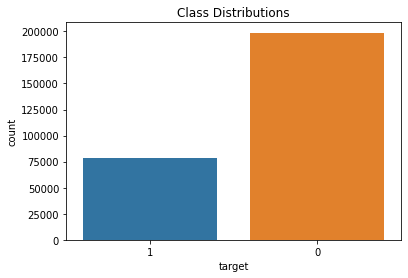

In [11]:
# Showing the class distribution of the dataset, We find that the negative is way more than the positives.
sns.countplot(x=df_data.target).set_title("Class Distributions")

In [12]:
from sklearn.model_selection import train_test_split

y = df_data['target']

_, df_test = train_test_split(df_data, test_size=0.03603, random_state=42, stratify=y)

_, df_val = train_test_split(df_data, test_size=0.0036025, random_state=42, stratify=y)

print('Valid:', df_val.shape[0])
print('Test:', df_test.shape[0])

Valid: 1000
Test: 10000


Text(0.5, 1.0, 'Valid Class Distributions')

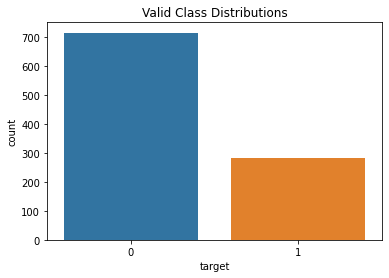

In [13]:
sns.countplot(x=df_val['target']).set_title('Valid Class Distributions')

Text(0.5, 1.0, 'Test Class Distributions')

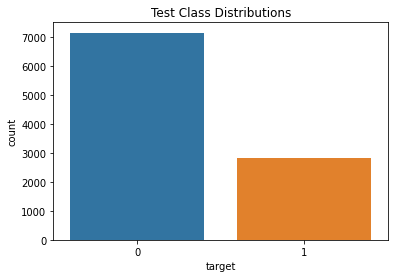

In [14]:
sns.countplot(x=df_test['target']).set_title('Test Class Distributions')

In [15]:
# Improved the speed of the identification through using a dictionary... Dramatically.
val_dict = df_val.set_index('image_id').T.to_dict('list')
test_dict = df_test.set_index('image_id').T.to_dict('list')

def identify_train_val_and_test_rows(x):
    if str(x) in val_dict:
        return 'val'
    elif str(x) in test_dict:
        return 'test'
    else:
        return 'train'

# create a new colum that is a copy of the image_id column
df_data['train_or_val_or_test'] = df_data['image_id']
# apply the function to this new column
df_data['train_or_val_or_test'] = df_data['train_or_val_or_test'].apply(identify_train_val_and_test_rows)
   
# filter out train rows
df_train = df_data[df_data['train_or_val_or_test'] == 'train']

print('Train:', len(df_train))
print('Valid:', len(df_val))
print('Test:', len(df_test))
df_data.head()

Train: 267524
Valid: 1000
Test: 10000


,image_id,patient_id,target,train_or_val_or_test
0,/kaggle/input/breast-histopathology-images/102...,10295,1,train
1,/kaggle/input/breast-histopathology-images/102...,10295,1,train
2,/kaggle/input/breast-histopathology-images/102...,10295,1,train
3,/kaggle/input/breast-histopathology-images/102...,10295,1,train
4,/kaggle/input/breast-histopathology-images/102...,10295,1,train


Text(0.5, 1.0, 'Train Class Distributions')

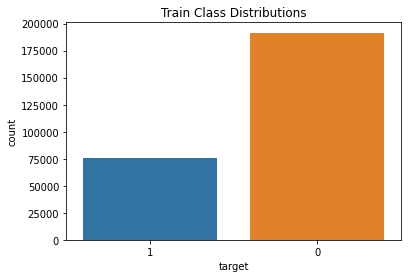

In [16]:
sns.countplot(x=df_train['target']).set_title('Train Class Distributions')

In [17]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)
og_train = df_train.copy()
df_data.head()

,patient_id,target,train_or_val_or_test
image_id,,,
/kaggle/input/breast-histopathology-images/10295/1/10295_idx5_x1601_y1501_class1.png,10295,1,train
/kaggle/input/breast-histopathology-images/10295/1/10295_idx5_x1351_y1751_class1.png,10295,1,train
/kaggle/input/breast-histopathology-images/10295/1/10295_idx5_x1451_y1601_class1.png,10295,1,train
/kaggle/input/breast-histopathology-images/10295/1/10295_idx5_x1351_y1451_class1.png,10295,1,train
/kaggle/input/breast-histopathology-images/10295/1/10295_idx5_x1251_y1801_class1.png,10295,1,train


# Augmentation

In [38]:
from keras.preprocessing.image import ImageDataGenerator

image_size = 100

# create temporary directories here and delete these directories later
aug_dir = '/kaggle/working/aug_dir'
if os.path.exists(aug_dir) == False:
  os.mkdir(aug_dir)
# create a dir within the base dir to store images of the same class
img_dir = os.path.join(aug_dir, 'img_dir')

if os.path.exists(img_dir) == False:
  os.mkdir(img_dir)

img_dir = os.path.join(str(img_dir) + '/1')

# list all images in that directory
if os.path.exists(img_dir) == False:
    os.mkdir(img_dir)

df_train = og_train.copy()

# point to a dir containing the images and not to the images themselves

# create a data generator
datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=[0.5,1.2],
    fill_mode='reflect'
)

batch_size = 25
aug_datagen = datagen.flow_from_dataframe(dataframe=df_train,
                                          x_col='image_id',
                                          y_col='target',
                                          target_size=(image_size, image_size),
                                          batch_size=batch_size,
                                          save_to_dir=img_dir,
                                          save_foramt='jpg'
)

# generate the augmented images and add them to the folder of all images

neg_images = df_train.loc[df_train['target'] == '0']

num_aug_images_wanted = len(neg_images) # total number of images wanted in each class

# num_files = len(os.listdir(img_dir))
num_files = len(aug_datagen)
num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

for i in range(0, num_batches):
  next(aug_datagen)

print("finished generation")

Found 267524 validated image filenames belonging to 2 classes.
finished generation


In [39]:
# Check how many train images
print('Train Total:', len(df_train.loc[df_train['target'] == '0', 'image_id'])+ len(df_train.loc[df_train['target'] == '1', 'image_id']))
print('Train Positive:', len(df_train.loc[df_train['target'] == '1']))
print('Train Negative:', len(df_train.loc[df_train['target']== '0']))

Train Total: 267524
Train Positive: 75947
Train Negative: 191577


In [43]:
aug_images_list = os.listdir("/kaggle/working/aug_dir/img_dir/1")
aug_images_df = pd.DataFrame(aug_images_list, columns=['image_id'])
aug_images_df['image_id'] = aug_images_df['image_id'].apply(lambda x: str("/kaggle/working/aug_dir/img_dir/1/") + x)
aug_images_df.insert(1, 'target', '1')
aug_images_df.insert(2, 'train_or_val_or_test', 'train')
aug_images_df.insert(3, 'patient_id', '0')
aug_images_df.set_index('image_id')

final_df_train = df_train.append(aug_images_df)

In [49]:
aug_images_df.head()

,image_id,target,train_or_val_or_test,patient_id
0,/kaggle/working/aug_dir/img_dir/1/_75533_16369...,1,train,0
1,/kaggle/working/aug_dir/img_dir/1/_264524_9648...,1,train,0
2,/kaggle/working/aug_dir/img_dir/1/_171815_9546...,1,train,0
3,/kaggle/working/aug_dir/img_dir/1/_138134_8076...,1,train,0
4,/kaggle/working/aug_dir/img_dir/1/_167960_4917...,1,train,0


In [44]:
print(len(final_df_train))

448424


In [46]:
num_train_samples = len(final_df_train)
num_val_samples = len(df_val)

train_batch_size = 500
val_batch_size = 500

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [47]:
datagen = ImageDataGenerator(preprocessing_function=keras.applications.inception_v3.preprocess_input, 
                             horizontal_flip=True,
                             vertical_flip=True)

train_batches_bench = datagen.flow_from_dataframe(final_df_train, 
                                                  target_size=(image_size, image_size),
                                                  batch_size=train_batch_size,
                                                  x_col='image_id',
                                                  y_col='target')

valid_batches_bench = datagen.flow_from_dataframe(df_val, 
                                                  target_size=(image_size, image_size),
                                                  batch_size=val_batch_size,
                                                  x_col='image_id',
                                                  y_col='target')

test_batches_bench = datagen.flow_from_dataframe(df_test,
                                                 target_size=(image_size, image_size),
                                                 batch_size=1,
                                                 shuffle=False,
                                                 x_col='image_id',
                                                 y_col='target')

Found 448424 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 10000 validated image filenames belonging to 2 classes.


In [50]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = tf.keras.applications.vgg19.VGG19(
    include_top=False,			# We do not want the classifier on top of the VGG19, we will use our own classifier
    weights=None,			# We want the imagenet weights
    input_shape=(image_size, image_size, 3)	# The input shape is 100, 100, 3 (RGB)
)

2022-11-08 22:20:13.872762: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-08 22:20:14.135924: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 22:20:14.136780: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 22:20:14.137527: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [51]:
x = tf.keras.layers.Flatten()(vgg.output)  # One flatten layer
prediction = tf.keras.layers.Dense(2, activation='softmax')(x) # one softmax layer
model = tf.keras.Model(inputs=vgg.input, outputs=prediction)   # Final Model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [ ]:
# This needs to be checked
# We need to know which data to be added exactly. We want the Image Data Generator function but without any agumentation (for now)
# did not have time to check exactly how. 
# Try to compare with the paper stuff. Hopefully we will be able to find something.
from tensorflow.keras.callbacks import ModelCheckpoint
model_checkpoint = ModelCheckpoint(filepath='breast_histopathology_baseline_NOAUG.hdf5', verbose=1, save_best_only=True)

class_weights={
    0: 1.0, # negative
    1: 1.0, # postive 
    # make model more sensitive to positive class if necessary
}

# using RMSProp optimizer as it  is the best optimizers according to this paper:
# https://www.sciencedirect.com/science/article/pii/S2214785321013316
model.compile(loss='categorical_crossentropy', optimizer='RMSProp', metrics=['accuracy']) 
history = model.fit(train_batches_bench, 
					steps_per_epoch=train_steps, 
					class_weight=class_weights,
					validation_data=valid_batches_bench,
					validation_steps=val_steps,
					callbacks=[model_checkpoint], 
					epochs=30, 
					verbose=1)

2022-11-08 22:20:28.801417: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 60000000 exceeds 10% of free system memory.
2022-11-08 22:20:29.011591: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-11-08 22:20:32.075298: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 60000000 exceeds 10% of free system memory.
2022-11-08 22:20:33.452053: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 60000000 exceeds 10% of free system memory.
2022-11-08 22:20:33.819341: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2022-11-08 22:20:34.821779: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 60000000 exceeds 10% of free system memory.
2022-11-08 22:20:36.243692: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 60000000 exceeds 10% of free system memory.


 40/897 [>.............................] - ETA: 22:21 - loss: 377.1760 - accuracy: 0.5584

In [ ]:
import matplotlib.pyplot as plt
training_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epoch_count = range(1, 31)

plt.figure()
plt.plot(epoch_count, training_acc, 'r--')
plt.plot(epoch_count, val_acc, 'b-')
plt.legend(['Training Acc', 'Validation Acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig("../vgg19_baseline_model_NOAUG.png")
plt.show()

In [ ]:
# Load Weights of the Baseline Model
model.load_weights('breast_histopathology_baseline_AUG.hdf5')

In [ ]:
# Test Predictions
preds = model.predict_generator(test_batches_bench, steps=len(df_test), verbose=1)

In [ ]:
# Accuracy using the baseline model
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
# Take the highest probability scores to get index of predictions for test images
y_pred = np.argmax(preds, axis=1)

# Get labels of test images
y_true = test_batches_bench.classes

# Evaluate
print(f'Accuracy: {accuracy_score(y_true, y_pred):1.3f}%')

print(f'Balanced Accuracy: {balanced_accuracy_score(y_true, y_pred):1.3f}%')
# Balanced accuracy is calculated as the average of the proportion correct of each class individually

f = open("../testOutput_NoAUG.txt", "w")
f.write(f'Accuracy: {accuracy_score(y_true, y_pred):1.3f}%\n')
f.write(f'Balanced Accuracy: {balanced_accuracy_score(y_true, y_pred):1.3f}%\n')
f.close()

In [ ]:
# Confusion matrix for the baseline model
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_true, y_pred)
plt.imshow(conf_matrix, interpolation='nearest', cmap='viridis')
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(['negative', 'positive']))
plt.xticks(tick_marks, ['negative', 'positive'])
plt.yticks(tick_marks, ['negative', 'positive'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig("../vgg19-baseline-model-confusion-matrix-NoAUG.png")

In [ ]:
confusionmatrix = confusion_matrix(y_true, y_pred)

f = open("../testOutput_NoAUG.txt", "a")
f.write(f'Confusion matrix: {confusionmatrix}\n')
f.close()

confusionmatrix

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_true=y_true, y_pred=y_pred, target_names=['negative', 'positive'])

f = open("../testOutput_NoAUG.txt", "a")
f.write(f'REPORT:\n {report}\n')
f.close()

print(report)

In [ ]:
x, y = valid_batches_bench.next()

for i in range(1,10):
  
  image = x[i]
  label = y[i]
#   f = open("../testOutput_NoAUG.txt", "a")
  if np.argmax(label, axis=0) == 0:
      print('IDC negative')
#       f.write(f'IDC negative\n')
  if np.argmax(label, axis=0) == 1:
    print('IDC positive')
#     f.write(f'IDC positive\n')

#   print(image.shape)
#   prob = model.predict(image)
#   for a in prob:
#     for b in a:
#       print(f'Predicted Negative Probability: {(b*100):1.2f}%')
#       print(f'Predicted Positive Probability: {(1-b)*100:1.2f}%')
#       f.write(f'Predicted Negative Probability: {(b*100):1.2f}%\n')
#       f.write(f'Predicted Positive Probability: {(1-b)*100:1.2f}%\n')
#       break

  plt.imshow(image)
#   f.write(image)
  plt.show()
#   f.close()